**1. Problem Statement :<br>**
How to identify customers who are most likely subscribe to term deposits. The customers will be contacted via call centers and hence
involve some cost in calling. Hence major consideration would be to avoid calls to customers who are less likely to purchase term deposit. 

**2. Selecting the metrics for model evaluation :<br>**
True Positive  : Model Prediction - Will Subscribe , Customer opts - Subscription<br>
True Negative  : Model Prediction - Will not subscribe , Customer opts - No subscription<br>
False Positive : Model Prediction - Will Subscribe , Customer opts - No subscription. These cases should be minimal                    because there is a cost involved in calling customers - 8 Euro.<br>
False Negative : Model Prediction - Will not subscribe , Customer opts - Subscription. These cases should also be                      minimal because if we lose one customer Znailla will lost around 80 Euro<br>

Among False Positives and False Negatives, it looks like False Negative cases we should reduce as much as possible because each loss of subscription can result
in a revenue loss of 80 Euro.

We will use the below as the final evaluation metrics :

* Accuracy Score 
* Precision 
* Recall 
* F1-Score


In [1]:
# Import needed libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn import preprocessing 

# Set Options
pd.options.display.max_columns = 500
pd.options.display.max_rows    = 500 

In [2]:
# Methods used 

# Prepare a summary of the data
def summarize_data(df, target):
    print('Shape of the dataset=',df.shape,'\n')
    print('Sample rows of the dataset:\n\n',df.head(5),'\n')
    print('Statistical Summary:\n',df.describe(),'\n')
    print('Target Distribution:\n', df.groupby(target).size(),'\n')
    print('Datatype:\n', df.info())
    
    
# Prepare the visualisation for an independent feature against the target
def prepare_independent_target_relation(df, col, target, plotTitle ):
    targetLabel = 'Subscription'
    # Extract data for visualisation
    tmpdf                 = pd.DataFrame(columns=[col, targetLabel])
    tmpdf[col]            = df[col]
    tmpdf[targetLabel]    = df[target]
    tmpdf[targetLabel]    = df[target].astype(str)
    tmpdf[targetLabel]    = tmpdf[targetLabel].replace(['no','yes'], ['Not Subscribed','Subscribed'])

    # Visualise extracted data

    crosstb = pd.crosstab(tmpdf[col], tmpdf[targetLabel])
    bars = crosstb.plot.bar(width=0.9, color=['orange','green'], stacked=True, figsize=(10,5), ylabel='Count', title=plotTitle)

    #print(crosstb)

**3. Understand the data**

**3.1 Metadata**<br>
age : Age of person<br>
job : Occupation<br>
marital : Marital status<br>
education : Education Level<br>
default : Has credit in default?<br>
housing : Has housing loan<br>
loan : Has personal loan<br>
contact : Contact communication type<br>
month : Last contact month of the year<br>
day_of_week : Last contact day of the week<br>
duration : Last contact duration, in seconds<br>
campaign : Number of contacts performed during this campaign for the client<br>
pdays : Number of days that passed by after the client was last contacted from a previous campaign( -1 means client not previously contacted)<br>
previous : Number of contacts performed before this campaign and for this client<br>
poutcome : Outcome of the previous marketing campaign<br>
emp_var_rate: Employment variation rate - quarterly indicator (numeric). Negative indicator which impact purchasing decision of the customer.<br>
cons_price_idx : Consumer price index - monthly indicator (numeric)<br>
cons_conf_idx : Consumer confidence index - monthly indicator (numeric)<br>
euribor3m : Euribor 3 month rate - daily indicator (numeric)<br>
nr.employed : number of employees - quarterly indicator (numeric)<br>
y : Has the client subscribed a term deposit<br><br>

**3.2 Descriptive Statistics<br>**

In [3]:
# Read input dataset

df_train = pd.read_csv('/kaggle/input/bank-additional-full1-csv/bank-additional-full.csv', delimiter=';')
summarize_data(df_train, 'y')

Shape of the dataset= (41188, 21) 

Sample rows of the dataset:

    age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  duration  campaign  pdays  previous     poutcome  \
0   may         mon       261         1    999         0  nonexistent   
1   may         mon       149         1    999         0  nonexistent   
2   may         mon       226         1    999         0  nonexistent   
3   may         mon       151         1    999         0  nonexistent   
4   may         mon       307         1    999         0  nonexistent   

   emp.var.rate  cons.price.idx  cons.

**Inferences**<br>
* There are 41188 observations and 20 features
* No null values in the dataset but for categorical variables there is a category of 'unknown'. This needs to be analysed further to see the % of 'unknown' values. This will help in making a decision if need to include that feature in model building or not.
 

**3.3 Analyse the percentage of 'unknown' values in each column**<br>

In [4]:
# Count the number of "unknown" values in categorical columns
df_unknown = pd.DataFrame(columns=['Column','UnknownVal','UnknownPercent'])
uncols = []
counts = []
for col in df_train.select_dtypes(include=['object']).columns.tolist():
    if 'unknown' in df_train[col].values:
        cnt = df_train[col].value_counts()['unknown']
        if cnt > 0:
            uncols.append(col)
            counts.append(cnt)
df_unknown['Column'] = uncols
df_unknown['UnknownVal'] = counts
df_unknown['UnknownPercent'] = ( df_unknown['UnknownVal'] / df_train.shape[0] ) * 100.0
df_unknown

Column  UnknownVal  UnknownPercent
0        job         330        0.801204
1    marital          80        0.194231
2  education        1731        4.202680
3    default        8597       20.872584
4    housing         990        2.403613
5       loan         990        2.403613

**4. Data Visualizations**

**4.1 Univariate Plots**<br>
4.1.1 Density Plots : To know the distribution of each attribute 
<br><br>Inferences:<br>
* age, duration, pdays seem to follow Gaussian distribution

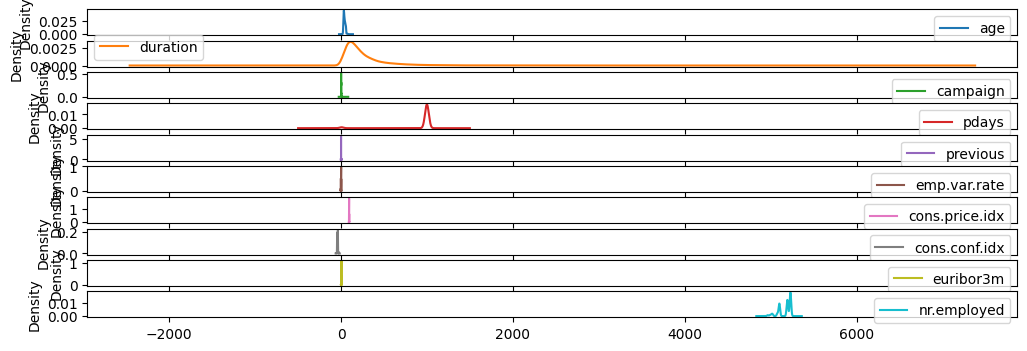

In [5]:
axs = df_train.plot.kde(figsize=(12, 4), subplots=True)
plt.show()

**4.1.2 Box and Whisker Plots : To know the spread of the data and outliers**
<br><br>Inferences:<br>
* Too many outliers present for age, duration and campaign.
* More than 90% of pdays value contain 999 which doesnt look to be a valid nr of days. So may be the data is not avaiable for them.

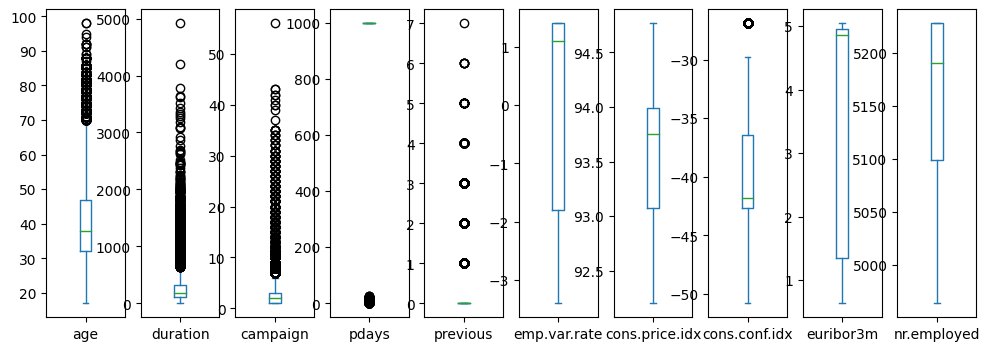

In [6]:
axs = df_train.plot(kind='box',figsize=(12, 4), subplots=True)
plt.show()

**4.3 Visualisation to show how the target is dependent up on different features**<br>
**Inferences:**<br>
* For age group above 60, there is a strong chance that more than 50% of the calls will turn to subscriptions. This may be an indicator that the bank should make more calls to people above 60 years.
* Among different job categories Admin, blue collar, technician and retired are most likely to subscribe
* Among different marital status, married ones are more tend to subscribe.
* month and day_of_week look to be not very much relevant to subscription rates.
* People with high education tend to subscribe more
* People without loan tend to take more deposits
* There is no observed significance for month and day_of_week
* It looks like previous contacts did help in making the customer subscribe
* Defaulters in credit rarely subscribe to term deposit
* People with personal loan rarely subscribe to term deposit

 

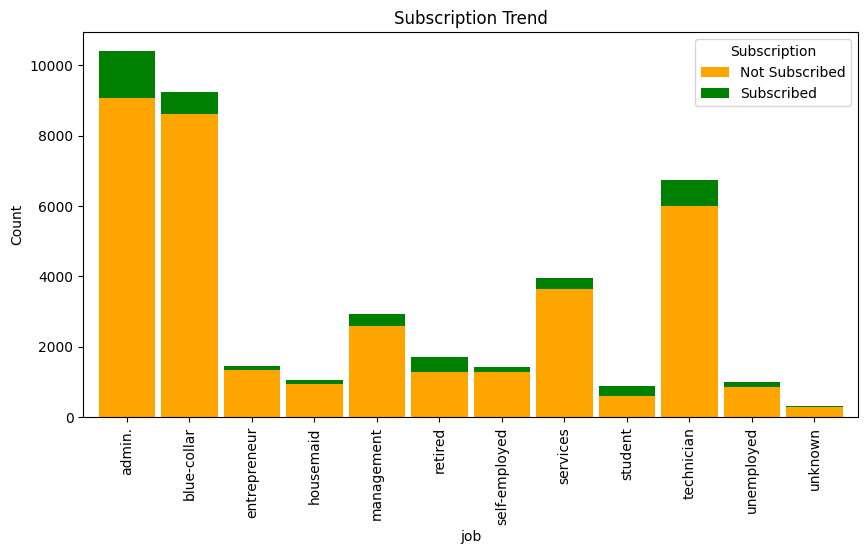

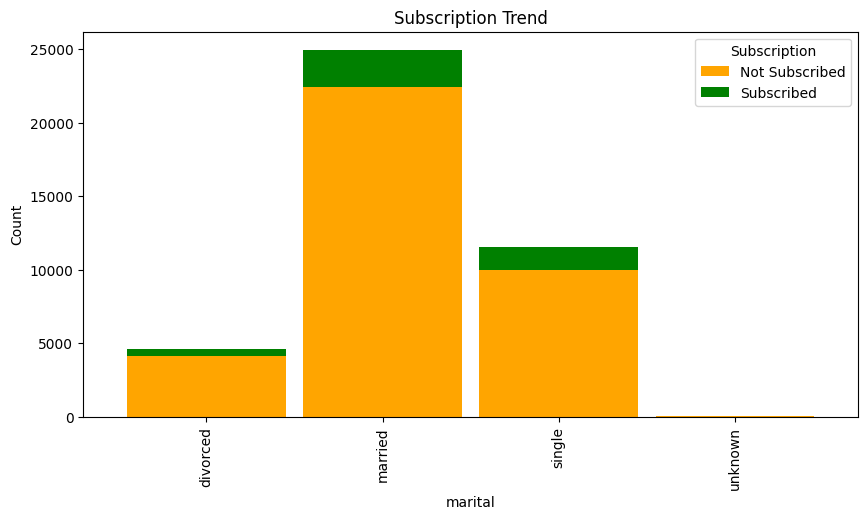

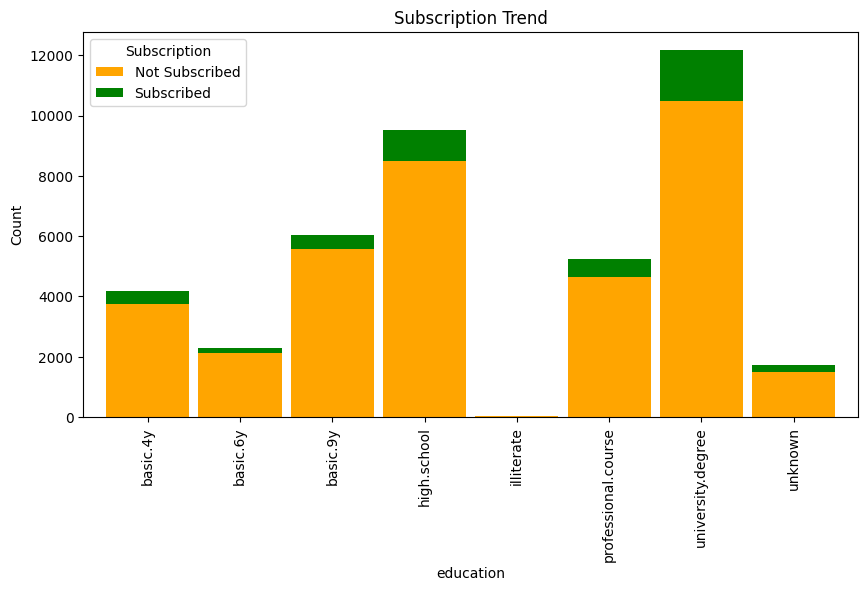

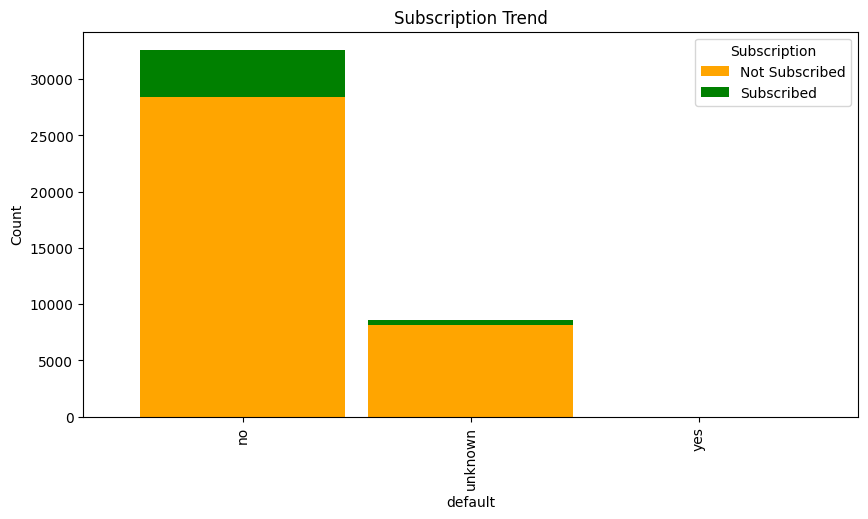

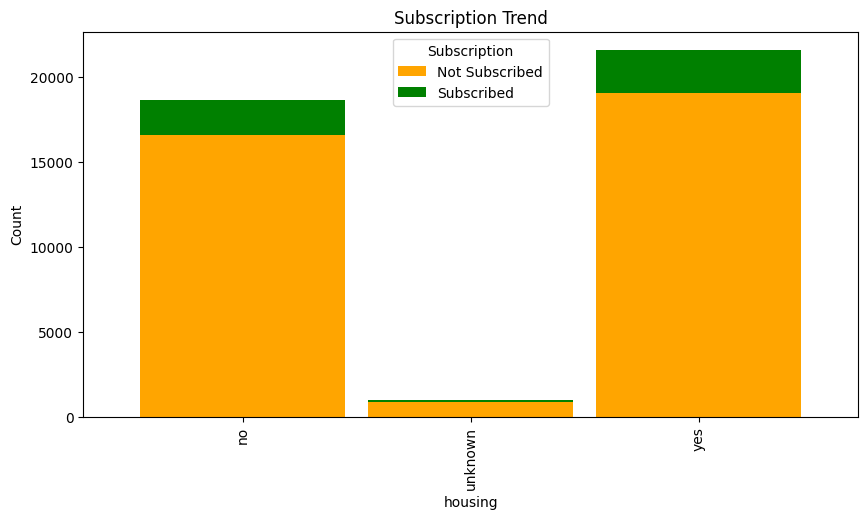

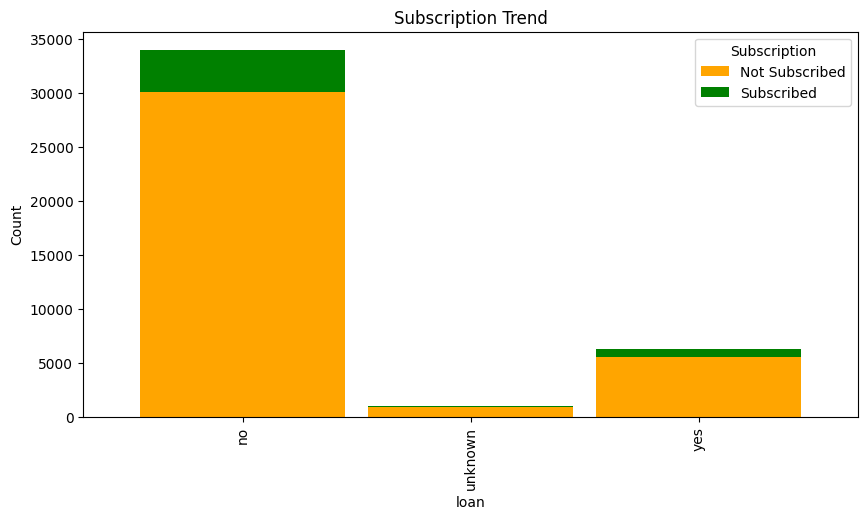

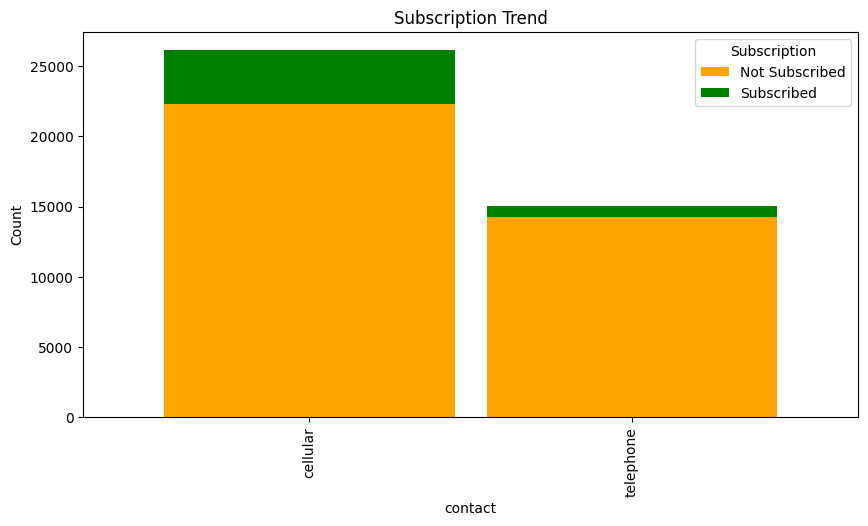

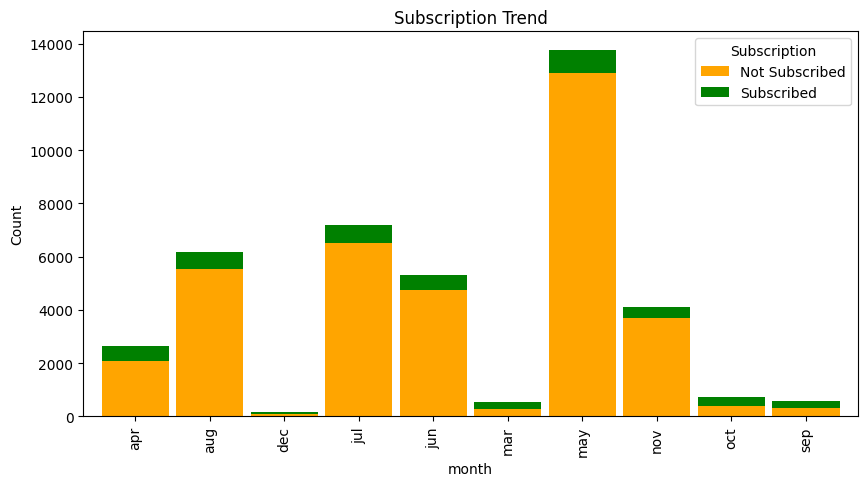

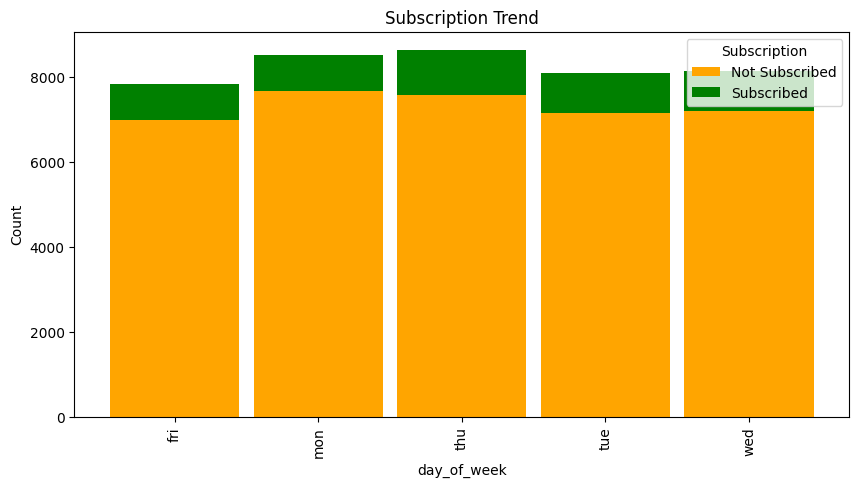

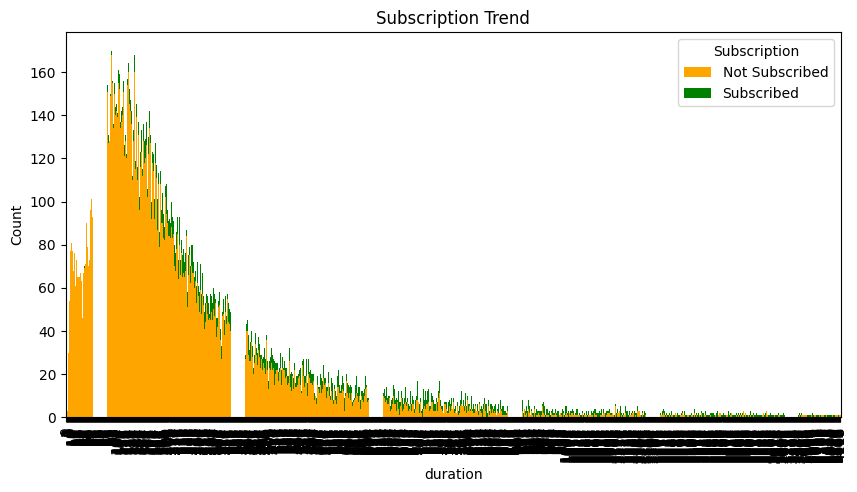

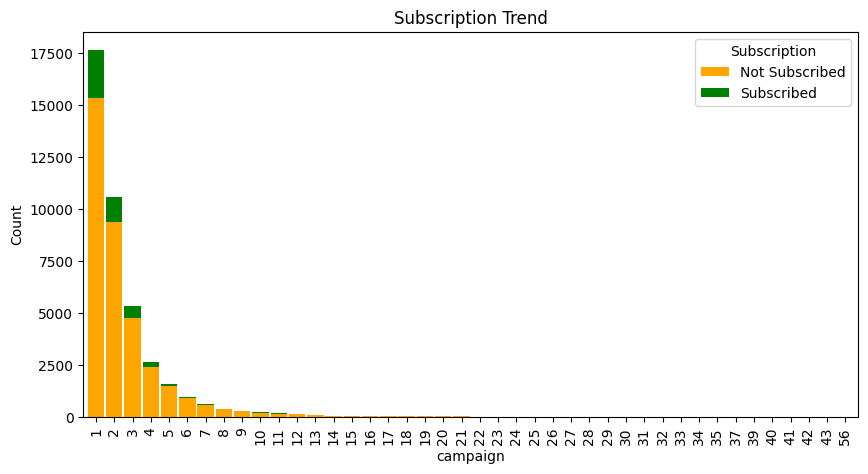

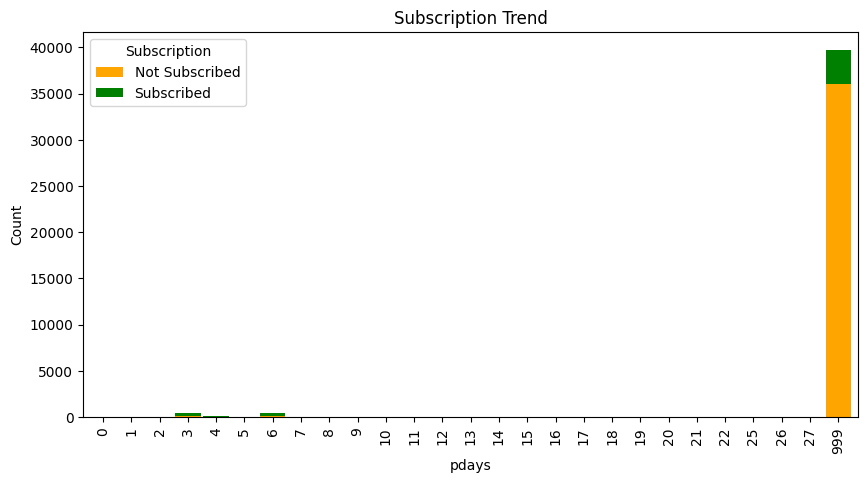

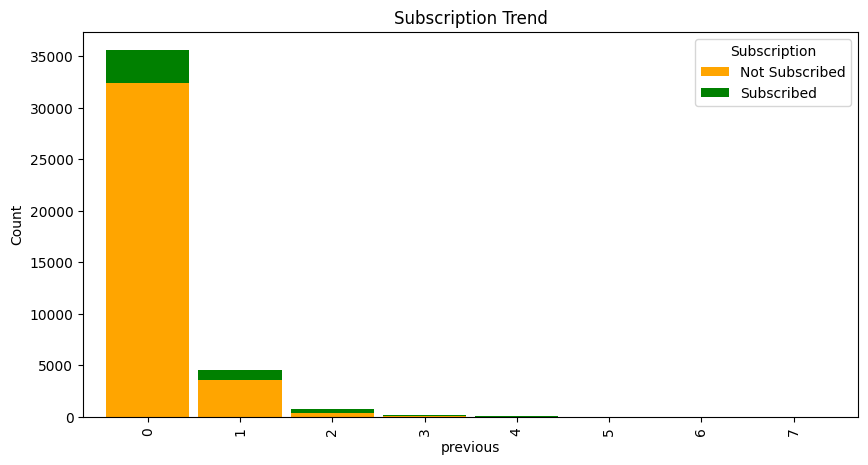

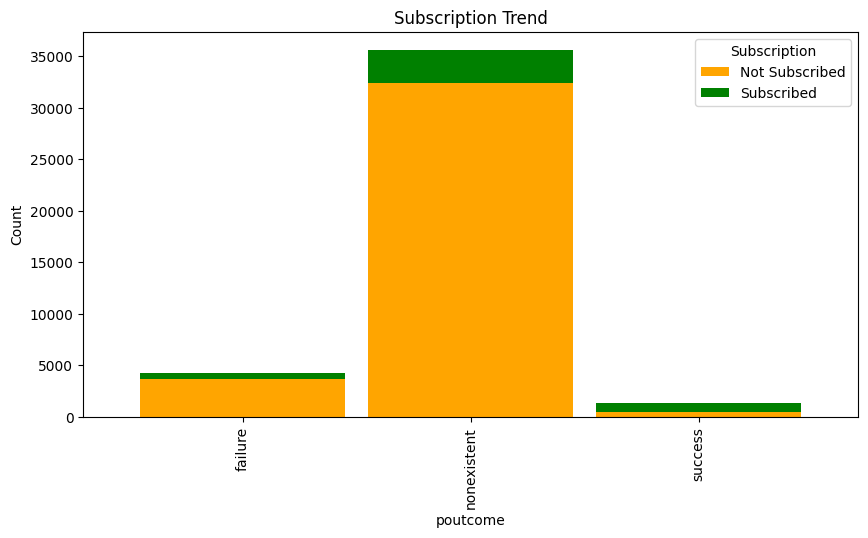

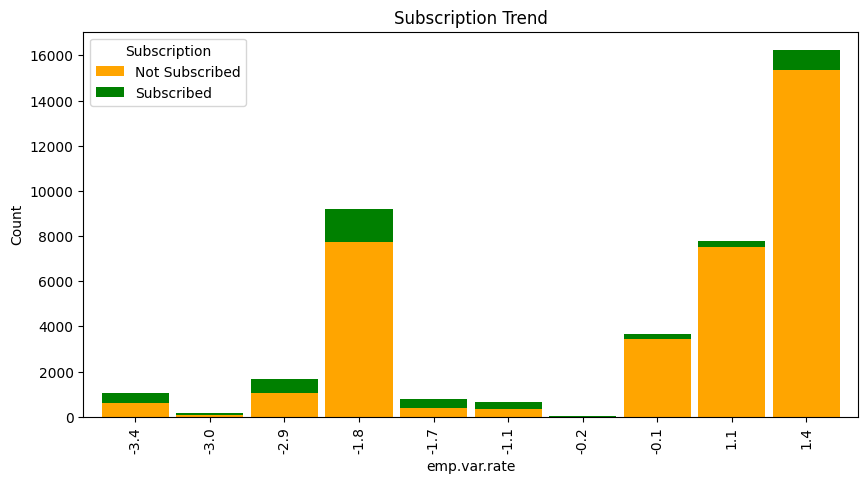

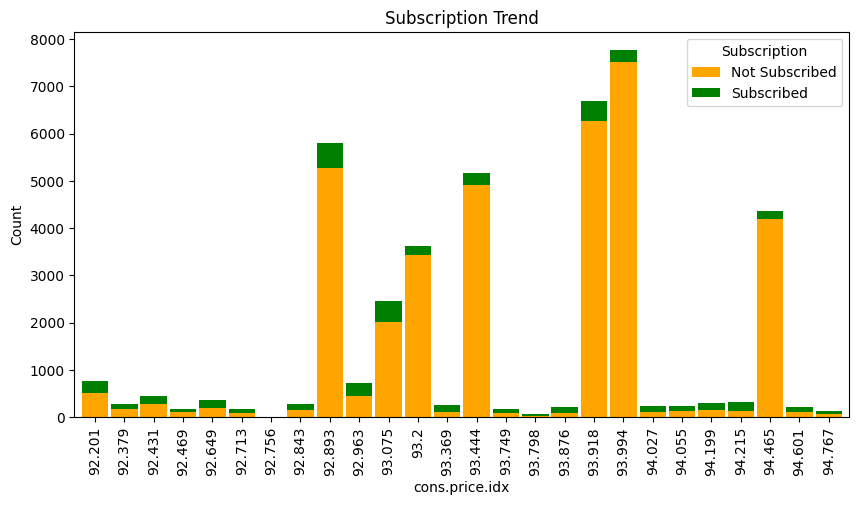

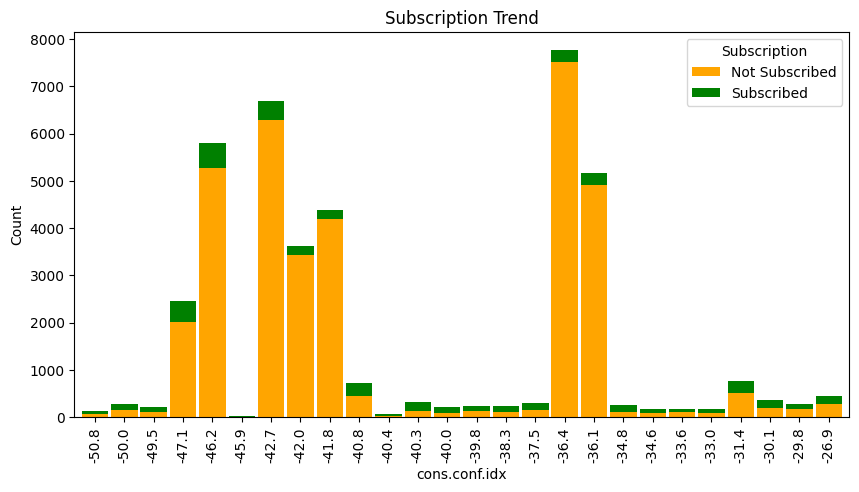

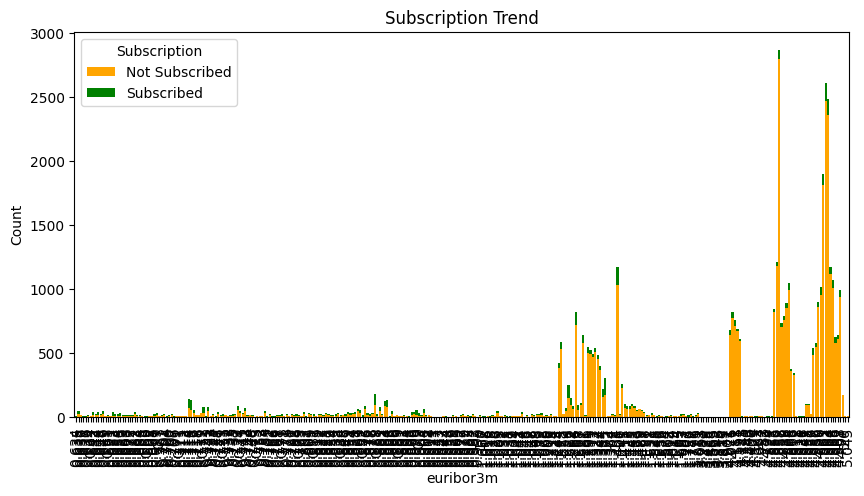

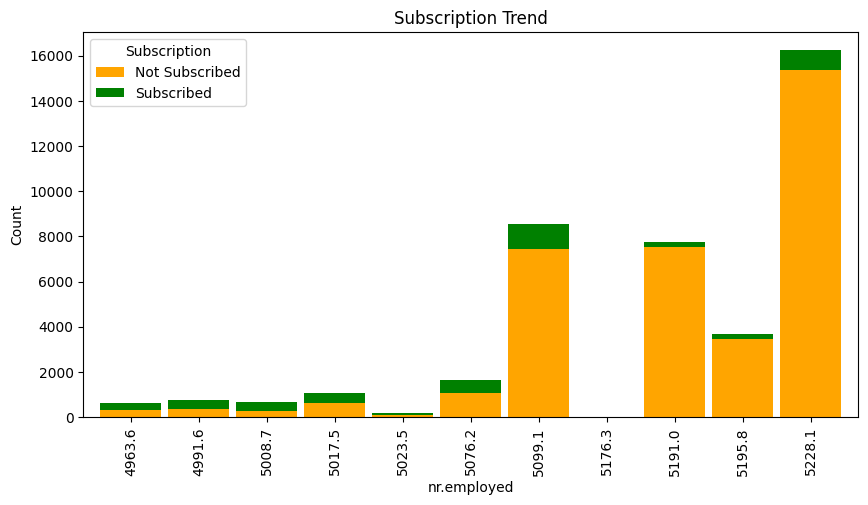

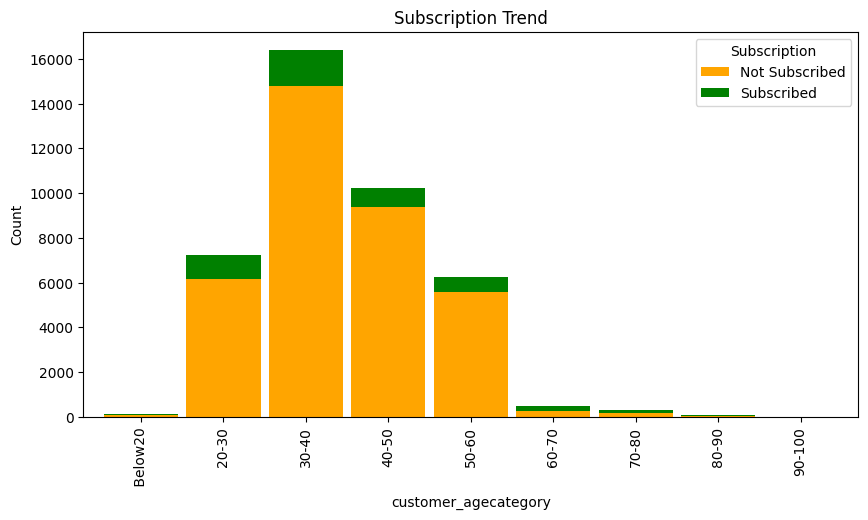

In [7]:
# Make age as a category as shown below 
df_train['customer_agecategory'] = pd.cut(df_train['age'], [0,20, 30, 40, 50, 60, 70, 80, 90,100], labels=[' Below20','20-30','30-40','40-50','50-60', '60-70', '70-80','80-90','90-100'])
df_train['customer_agecategory'] = df_train['customer_agecategory'].astype(str)
for c in df_train.columns:
    if c not in ['age','y']:
        prepare_independent_target_relation(df_train, c, 'y', 'Subscription Trend' )

Text(0, 0.5, 'Subscription: 0-No 1-Yes')

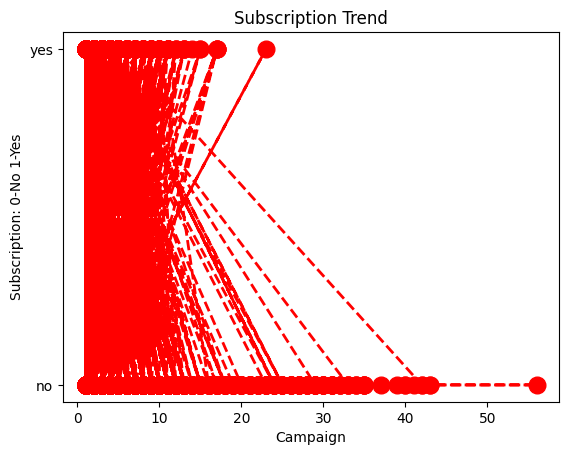

In [8]:
# Extract data for visualisation
plt.plot(df_train['campaign'], df_train['y'],color='red', marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.title('Subscription Trend')
plt.xlabel('Campaign')
plt.ylabel('Subscription: 0-No 1-Yes')

**5. Prepare Data**<br>

**5.1 Cleaning Data**

**5.1.1 Remove duplicate rows if any :** Could see there were 12 rows which were duplicates and hence removed.

In [9]:
print('Shape of the dataset before duplicate removal :', df_train.shape)
df_train.drop_duplicates(inplace=True)
print('Shape of the dataset after duplicate removal  :', df_train.shape)

Shape of the dataset before duplicate removal : (41188, 22)
Shape of the dataset after duplicate removal  : (41176, 22)


**5.1.2 Identify missing values in the dataset :** Could see no missing values

In [10]:
df_train.isna().sum()

age                     0
job                     0
marital                 0
education               0
default                 0
housing                 0
loan                    0
contact                 0
month                   0
day_of_week             0
duration                0
campaign                0
pdays                   0
previous                0
poutcome                0
emp.var.rate            0
cons.price.idx          0
cons.conf.idx           0
euribor3m               0
nr.employed             0
y                       0
customer_agecategory    0
dtype: int64

**5.1.3 Drop one of highly correlated features**

Inference:
* emp.var.rate highly correlates with cons.price.idx, euribor3m, nr.employed
* cons.price.idx highly correlates with euribor3m
* euribor3m highly correlates with nr.employed

In [11]:
# For target variable change yes - 1 and no - 0
df_train['y'].replace('yes',1, inplace=True)
df_train['y'].replace('no',0, inplace=True)
target = df_train['y']

colsToRemove = ['age']       # Will use customer_agecategory instead
colsToRemove.append('y')     # Remove target variable
colsToRemove.append('pdays') # More than 90% of pdays is 999 which looks to be an incorrect data., hence dropping
numericCols    = df_train.select_dtypes(exclude=['object']).columns.tolist()
categoricCols  = df_train.select_dtypes(include=['object']).columns.tolist()
print('Numeric Columns =',numericCols)
print('Categorical Columns =', categoricCols)

Numeric Columns = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']
Categorical Columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'customer_agecategory']


/tmp/ipykernel_18/1797226597.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['y'].replace('yes',1, inplace=True)
/tmp/ipykernel_18/1797226597.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

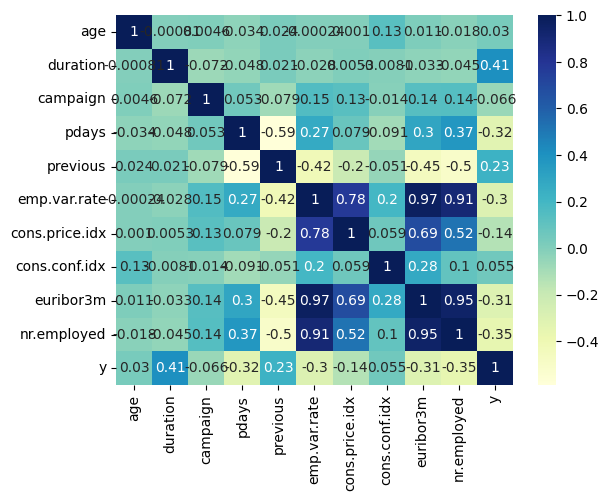

In [12]:
# Correlation between numeric columns 
corr = df_train[numericCols].corr()
sns.heatmap(corr, cmap="YlGnBu", annot=True) 
colsToRemove.append('cons.price.idx')
colsToRemove.append('euribor3m')
colsToRemove.append('nr.employed')
df_train.drop(columns=colsToRemove, inplace=True)

**5.1.4 Data imputation for columns having 'unknown' values**

In [13]:
colsNeedImputation = ['job', 'marital','education','default','housing','loan']
for c in colsNeedImputation:
    modeValue = df_train[c].mode()[0]
    df_train[c].replace('unknown',modeValue, inplace=True)

/tmp/ipykernel_18/3957183206.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train[c].replace('unknown',modeValue, inplace=True)


**5.2 Data Transformations**

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   job                   41176 non-null  object 
 1   marital               41176 non-null  object 
 2   education             41176 non-null  object 
 3   default               41176 non-null  object 
 4   housing               41176 non-null  object 
 5   loan                  41176 non-null  object 
 6   contact               41176 non-null  object 
 7   month                 41176 non-null  object 
 8   day_of_week           41176 non-null  object 
 9   duration              41176 non-null  int64  
 10  campaign              41176 non-null  int64  
 11  previous              41176 non-null  int64  
 12  poutcome              41176 non-null  object 
 13  emp.var.rate          41176 non-null  float64
 14  cons.conf.idx         41176 non-null  float64
 15  customer_agecategory  41

In [15]:
# Apply One Hot Encoding for those features that doesnt have any order
ohe_cols = ['job','marital','education','default','housing','loan','customer_agecategory','contact','poutcome']

# Apply label encoding for those features that preserve an order
lbl_cols = ['month','day_of_week'] 

# Label encoding   
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
df_train['month']= label_encoder.fit_transform(df_train['month']) 
df_train['day_of_week']= label_encoder.fit_transform(df_train['day_of_week'])

#Initialize OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Apply one-hot encoding to the categorical columns
one_hot_encoded = ohe.fit_transform(df_train[ohe_cols])    

#Create a DataFrame with the one-hot encoded columns
#We use get_feature_names_out() to get the column names for the encoded data
one_hot_df = pd.DataFrame(one_hot_encoded, columns=ohe.get_feature_names_out(ohe_cols))
one_hot_df.shape

# Concatenate the one-hot encoded dataframe with the original dataframe
df_encoded = pd.concat([df_train.reset_index(drop=True), one_hot_df.reset_index(drop=True)], axis=1)

# Drop the original categorical columns
df_encoded = df_encoded.drop(ohe_cols, axis=1)

# Display the resulting dataframe
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41176 entries, 0 to 41175
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   month                          41176 non-null  int64  
 1   day_of_week                    41176 non-null  int64  
 2   duration                       41176 non-null  int64  
 3   campaign                       41176 non-null  int64  
 4   previous                       41176 non-null  int64  
 5   emp.var.rate                   41176 non-null  float64
 6   cons.conf.idx                  41176 non-null  float64
 7   job_admin.                     41176 non-null  float64
 8   job_blue-collar                41176 non-null  float64
 9   job_entrepreneur               41176 non-null  float64
 10  job_housemaid                  41176 non-null  float64
 11  job_management                 41176 non-null  float64
 12  job_retired                    41176 non-null 

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


**6. Data Modelling**

**6.1 Building models with all features**

In [16]:
# Train a machine learning model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score

# Build different classification models

num_folds = 10
seed = 7
scoring = 'accuracy'
pipelines = []
X_train = df_encoded
y_train = target

pipelines.append(('LR', LogisticRegression())) 
pipelines.append(('LDA', LinearDiscriminantAnalysis())) 
pipelines.append(('KNN', KNeighborsClassifier())) 
pipelines.append(('CART', DecisionTreeClassifier())) 
pipelines.append(('SVM', SVC())) 
pipelines.append(('RF', RandomForestClassifier())) 
pipelines.append(('XGB', XGBClassifier())) 
pipelines.append(('CatBoost',CatBoostClassifier())) 

results = []
names = []
for name, model in pipelines:
    kfold = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LR: 0.907082 (0.003464)
LDA: 0.904459 (0.004134)
KNN: 0.894963 (0.003659)
CART: 0.887969 (0.003376)
SVM: 0.893530 (0.003030)
RF: 0.908393 (0.002881)
XGB: 0.910773 (0.002377)
Learning rate set to 0.048178
0:	learn: 0.6143914	total: 67.2ms	remaining: 1m 7s
1:	learn: 0.5604618	total: 77.7ms	remaining: 38.8s
2:	learn: 0.4994457	total: 87ms	remaining: 28.9s
3:	learn: 0.4597416	total: 94.8ms	remaining: 23.6s
4:	learn: 0.4283431	total: 103ms	remaining: 20.4s
5:	learn: 0.3999343	total: 112ms	remaining: 18.6s
6:	learn: 0.3774924	total: 120ms	remaining: 17.1s
7:	learn: 0.3507783	total: 129ms	remaining: 16s
8:	learn: 0.3337133	total: 138ms	remaining: 15.2s
9:	learn: 0.3150821	total: 146ms	remaining: 14.5s
10:	learn: 0.2998813	total: 155ms	remaining: 13.9s
11:	learn: 0.2883633	total: 163ms	remaining: 13.4s
12:	learn: 0.2737756	total: 171ms	remaining: 13s
13:	learn: 0.2645164	total: 179ms	remaining: 12.6s
14:	learn: 0.2544268	total: 188ms	remaining: 12.3s
15:	learn: 0.2494740	total: 195ms	remaining

**6.2 Reduce number of features by SelectKBest feature selection algorithm**

In [17]:
# SelectKBest algorithm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression

fs = SelectKBest(score_func=f_regression,k=20)
# Applying feature selection
fit = fs.fit(X_train,y_train)

features_score = pd.DataFrame(fit.scores_)
features = pd.DataFrame(X_train.columns)
feature_score = pd.concat([features,features_score],axis=1)
# Assigning column names
feature_score.columns = ["Input_Features","F_Score"]
print(feature_score.nlargest(20,columns="F_Score"))

                   Input_Features      F_Score
2                        duration  8092.864331
47               poutcome_success  4577.261793
5                    emp.var.rate  4021.298297
4                        previous  2304.020429
46           poutcome_nonexistent  1601.999567
44              contact_telephone   881.464614
43               contact_cellular   881.464614
39     customer_agecategory_60-70   517.856410
40     customer_agecategory_70-80   400.092449
15                    job_student   366.756502
12                    job_retired   354.282693
8                 job_blue-collar   229.376610
3                        campaign   182.121625
41     customer_agecategory_80-90   160.772146
27    education_university.degree   137.129021
37     customer_agecategory_40-50   131.363870
6                   cons.conf.idx   124.027852
34  customer_agecategory_ Below20   122.212694
20                 marital_single   121.348959
35     customer_agecategory_20-30   106.046456


**6.3 Rebuild model using selected features**

In [18]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate

results = []
names = []
cv_results = {}
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}
X_train = X_train[feature_score['Input_Features']]
for name, model in pipelines:
    kfold = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('Model =', model)
    print('Accuracy =', np.mean(cv_results['test_accuracy']))
    print('Precision =', np.mean(cv_results['test_precision']))
    print('Recall =', np.mean(cv_results['test_recall']))
    print('F1 Score =', np.mean(cv_results['test_f1_score']))
    

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Model = LogisticRegression()
Accuracy = 0.9070816606017551
Precision = 0.6513665590351271
Recall = 0.3780949765398078
F1 Score = 0.478015633720769
Model = LinearDiscriminantAnalysis()
Accuracy = 0.904458768727211
Precision = 0.6037759684316295
Recall = 0.4423377336709615
F1 Score = 0.5101084632413373
Model = KNeighborsClassifier()
Accuracy = 0.8949631015006304
Precision = 0.5468827159444679
Recall = 0.3979379235868027
F1 Score = 0.4604343019337171
Model = DecisionTreeClassifier()
Accuracy = 0.8871915663067043
Precision = 0.49962753119809306
Recall = 0.5130474044835034
F1 Score = 0.5059562660449414
Model = SVC()
Accuracy = 0.8935300427526421
Precision = 0.5917792100207859
Recall = 0.1797842034706189
F1 Score = 0.2754587896659176
Model = RandomForestClassifier()
Accuracy = 0.9078102403672661
Precision = 0.6369309894155387
Recall = 0.42380045803232286
F1 Score = 0.5085713632723503
Model = XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, co

**6.4 Selecting the best model and print the statistics**<br>
* From the above trials could see that reduction in number of features doesnt have a big impact in model performance.
* The model giving the best results is CatBoost
* The scores are as follows:<br>
Accuracy = 0.9138574960690242<br>
Precision = 0.646503202374036<br>
Recall = 0.5190763014820883<br>
F1 Score = 0.5757188103736031<br>

**6.5 Hyperparameter Tuning**

In [19]:
from sklearn.model_selection import GridSearchCV

parameters = {'depth'         : [4,5,6,7,8,9, 10],
              'learning_rate' : [0.01,0.02,0.03,0.04],
              'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
             }
Grid_CBC = GridSearchCV(estimator=CatBoostClassifier(), param_grid = parameters, cv = 2, n_jobs=-1)
Grid_CBC.fit(X_train, y_train)
    
print(" Results from Grid Search " )
print("\n Best parameters:\n",Grid_CBC.best_params_)


0:	learn: 0.6705073	total: 5.39ms	remaining: 48.5ms
1:	learn: 0.6574041	total: 9.95ms	remaining: 39.8ms
2:	learn: 0.6444337	total: 14.7ms	remaining: 34.2ms
3:	learn: 0.6304596	total: 19.8ms	remaining: 29.7ms
4:	learn: 0.6165249	total: 24.4ms	remaining: 24.4ms
5:	learn: 0.5990648	total: 28.9ms	remaining: 19.3ms
6:	learn: 0.5879713	total: 32.8ms	remaining: 14.1ms
7:	learn: 0.5679783	total: 37.2ms	remaining: 9.29ms
8:	learn: 0.5576990	total: 41.8ms	remaining: 4.64ms
9:	learn: 0.5468440	total: 46.4ms	remaining: 0us
0:	learn: 0.6722325	total: 4.68ms	remaining: 42.1ms
1:	learn: 0.6545934	total: 9.39ms	remaining: 37.6ms
2:	learn: 0.6372668	total: 14.1ms	remaining: 32.8ms
3:	learn: 0.6188377	total: 18.8ms	remaining: 28.2ms
4:	learn: 0.6030929	total: 23.2ms	remaining: 23.2ms
5:	learn: 0.5823002	total: 27.4ms	remaining: 18.2ms
6:	learn: 0.5635558	total: 31.6ms	remaining: 13.5ms
7:	learn: 0.5437913	total: 36.1ms	remaining: 9.02ms
8:	learn: 0.5294620	total: 40.7ms	remaining: 4.52ms
9:	learn: 0.511

In [20]:
from sklearn.model_selection import train_test_split

cb = CatBoostClassifier(depth= 4,iterations=10,learning_rate=0.01)
X = X_train
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train ,
                                   random_state=104,
                                   test_size=0.25,
                                   shuffle=True)
cb.fit(X_train, y_train)
y_pred = cb.predict(X_test)
print('Accuracy Score=',accuracy_score(y_test,y_pred))

0:	learn: 0.6786300	total: 6.38ms	remaining: 57.4ms
1:	learn: 0.6619410	total: 12.3ms	remaining: 49.2ms
2:	learn: 0.6506849	total: 17.8ms	remaining: 41.6ms
3:	learn: 0.6352132	total: 23.6ms	remaining: 35.4ms
4:	learn: 0.6206843	total: 29.4ms	remaining: 29.4ms
5:	learn: 0.6102343	total: 34.4ms	remaining: 22.9ms
6:	learn: 0.5976396	total: 40.1ms	remaining: 17.2ms
7:	learn: 0.5839257	total: 45.9ms	remaining: 11.5ms
8:	learn: 0.5725420	total: 53.2ms	remaining: 5.91ms
9:	learn: 0.5612230	total: 59.7ms	remaining: 0us
Accuracy Score= 0.9046046240528464


**7. Conclusion**
* Using CatBoost classifier, created a ML model. Using this model we can predict if a customer needs to be called or not. 
* Also the below indicators are also passed to management as the analysis result of data as described in data visualisation section.
<br>For age group above 60, there is a strong chance that more than 50% of the calls will turn to subscriptions. This may be an indicator that the bank should make more calls to people above 60 years.
<br>Among different job categories Admin, blue collar, technician and retired are most likely to subscribe
<br>Among different marital status, married ones are more tend to subscribe.
month and day_of_week look to be not very much relevant to subscription rates.
<br>People with high education tend to subscribe more
<br>People without loan tend to take more deposits
<br>There is no observed significance for month and day_of_week
<br>It looks like previous contacts did help in making the customer subscribe
<br>Defaulters in credit rarely subscribe to term deposit
<br>People with personal loan rarely subscribe to term deposit